In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dataset = pd.read_csv("dataset/nps_simulated_dataset_gaussiano_2025-08-08.csv")
print("Number of rows: ", dataset.shape[0])
print("Number of columns: ", dataset.shape[1])
dataset.head(20)

Number of rows:  10000
Number of columns:  21


,simulation_id,sensor_id,sensor_x,sensor_y,sensor_noise,sensor_height,days,RH,humidify,wind_type,...,wind_dir,stability_profile,stability_value,aerosol_type,source_x,source_y,source_h,emission_rate,real_concentration,contratio_series
0,0,0,1.0,2.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"2.036756289725936e-10,7.746403728087358e-11,1...."
1,0,1,274.0,21.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"5.400567843799803e-10,7.896154493629639e-11,1...."
2,0,2,166.0,103.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"0.0,3.738415300353007e-10,8.896007738156253e-1..."
3,0,3,130.0,229.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"2.2418948171564444e-10,3.0737799433089084e-11,..."
4,0,4,123.0,274.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"3.7239198523556254e-11,5.367155129155546e-10,3..."
5,0,5,222.0,298.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"3.1866822808378526e-10,1.1554004867826052e-10,..."
6,0,6,271.0,151.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"2.0580441846850947e-10,1.0428488277061772e-10,..."
7,0,7,219.0,69.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"8.30673951102076e-11,0.0,8.647448027615246e-12..."
8,0,8,254.0,103.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"1.9523254054175496e-10,6.20315984393872e-11,9...."
9,0,9,193.0,129.0,0.0004,2.0,20,0.68,True,CONSTANT,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",CONSTANT,PasquillGiffordStability.MODERATELY_STABLE,CATHINONE_ANALOGUES,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"3.281839264589271e-11,9.609218831606335e-12,1...."


In [ ]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   simulation_id       10000 non-null  int64  
 1   sensor_id           10000 non-null  int64  
 2   sensor_x            10000 non-null  float64
 3   sensor_y            10000 non-null  float64
 4   sensor_noise        10000 non-null  float64
 5   sensor_height       10000 non-null  float64
 6   days                10000 non-null  int64  
 7   RH                  10000 non-null  float64
 8   humidify            10000 non-null  bool   
 9   wind_type           10000 non-null  object 
 10  wind_speed          10000 non-null  float64
 11  wind_dir            10000 non-null  object 
 12  stability_profile   10000 non-null  object 
 13  stability_value     10000 non-null  object 
 14  aerosol_type        10000 non-null  object 
 15  source_x            10000 non-null  float64
 16  sourc

In [3]:
dataset.isnull().sum()

simulation_id         0
sensor_id             0
sensor_x              0
sensor_y              0
sensor_noise          0
sensor_height         0
days                  0
RH                    0
humidify              0
wind_type             0
wind_speed            0
wind_dir              0
stability_profile     0
stability_value       0
aerosol_type          0
source_x              0
source_y              0
source_h              0
emission_rate         0
real_concentration    0
contratio_series      0
dtype: int64

In [4]:
dataset.describe()

,simulation_id,sensor_id,sensor_x,sensor_y,sensor_noise,sensor_height,days,RH,wind_speed,source_x,source_y,source_h,emission_rate
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,499.500000,4.500000,151.061900,150.853500,0.000257,2.0,20.0,0.254930,3.782910,142.988000,149.428000,5.555010,0.005054
std,288.689425,2.872425,87.621212,87.132886,0.000146,0.0,0.0,0.325838,1.709186,85.520473,85.219699,2.584697,0.002920
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,20.0,0.000000,0.500000,0.000000,0.000000,1.000000,0.000100
25%,249.750000,2.000000,75.000000,74.000000,0.000100,2.0,20.0,0.000000,2.457500,74.000000,78.750000,3.470000,0.002400
50%,499.500000,4.500000,152.000000,152.000000,0.000300,2.0,20.0,0.010000,3.640000,138.000000,148.000000,5.525000,0.005000
75%,749.250000,7.000000,227.000000,227.000000,0.000400,2.0,20.0,0.512500,4.950000,212.000000,222.000000,7.870000,0.007700
max,999.000000,9.000000,299.000000,299.000000,0.000500,2.0,20.0,0.980000,7.980000,299.000000,299.000000,9.990000,0.010000


In [5]:
print(dataset["wind_dir"][1])
print(type(dataset["wind_dir"][1]))


0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
datset_copy= dataset.copy()

In [8]:
type(datset_copy['contratio_series'][0])


str

In [9]:
def convert_string_to_array(s):
    if isinstance(s, str):
        s = s.replace('[', '').replace(']', '')
        return np.fromstring(s, sep=',')
    return s

In [10]:

datset_copy["contratio_series"] = datset_copy["contratio_series"].apply(convert_string_to_array)
type(datset_copy['contratio_series'][0])

numpy.ndarray

In [11]:
datset_copy=dataset.copy()

In [12]:
def convert_string_to_array(s):
	if isinstance(s, str):
		s = s.replace('[', '').replace(']', '')
		return np.fromstring(s, sep=',')
	return s

datset_copy["wind_dir"] = datset_copy["wind_dir"].apply(convert_string_to_array)
#datset_copy["concentration"] = datset_copy["concentration"].apply(convert_string_to_array)

In [13]:
datset_copy["wind_dir"]

0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
9995    [160.27262259555116, 5.194093088118388, 123.75...
9996    [160.27262259555116, 5.194093088118388, 123.75...
9997    [160.27262259555116, 5.194093088118388, 123.75...
9998    [160.27262259555116, 5.194093088118388, 123.75...
9999    [160.27262259555116, 5.194093088118388, 123.75...
Name: wind_dir, Length: 10000, dtype: object

In [14]:
datset_copy.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   simulation_id       10000 non-null  int64  
 1   sensor_id           10000 non-null  int64  
 2   sensor_x            10000 non-null  float64
 3   sensor_y            10000 non-null  float64
 4   sensor_noise        10000 non-null  float64
 5   sensor_height       10000 non-null  float64
 6   days                10000 non-null  int64  
 7   RH                  10000 non-null  float64
 8   humidify            10000 non-null  bool   
 9   wind_type           10000 non-null  object 
 10  wind_speed          10000 non-null  float64
 11  wind_dir            10000 non-null  object 
 12  stability_profile   10000 non-null  object 
 13  stability_value     10000 non-null  object 
 14  aerosol_type        10000 non-null  object 
 15  source_x            10000 non-null  float64
 16  sourc

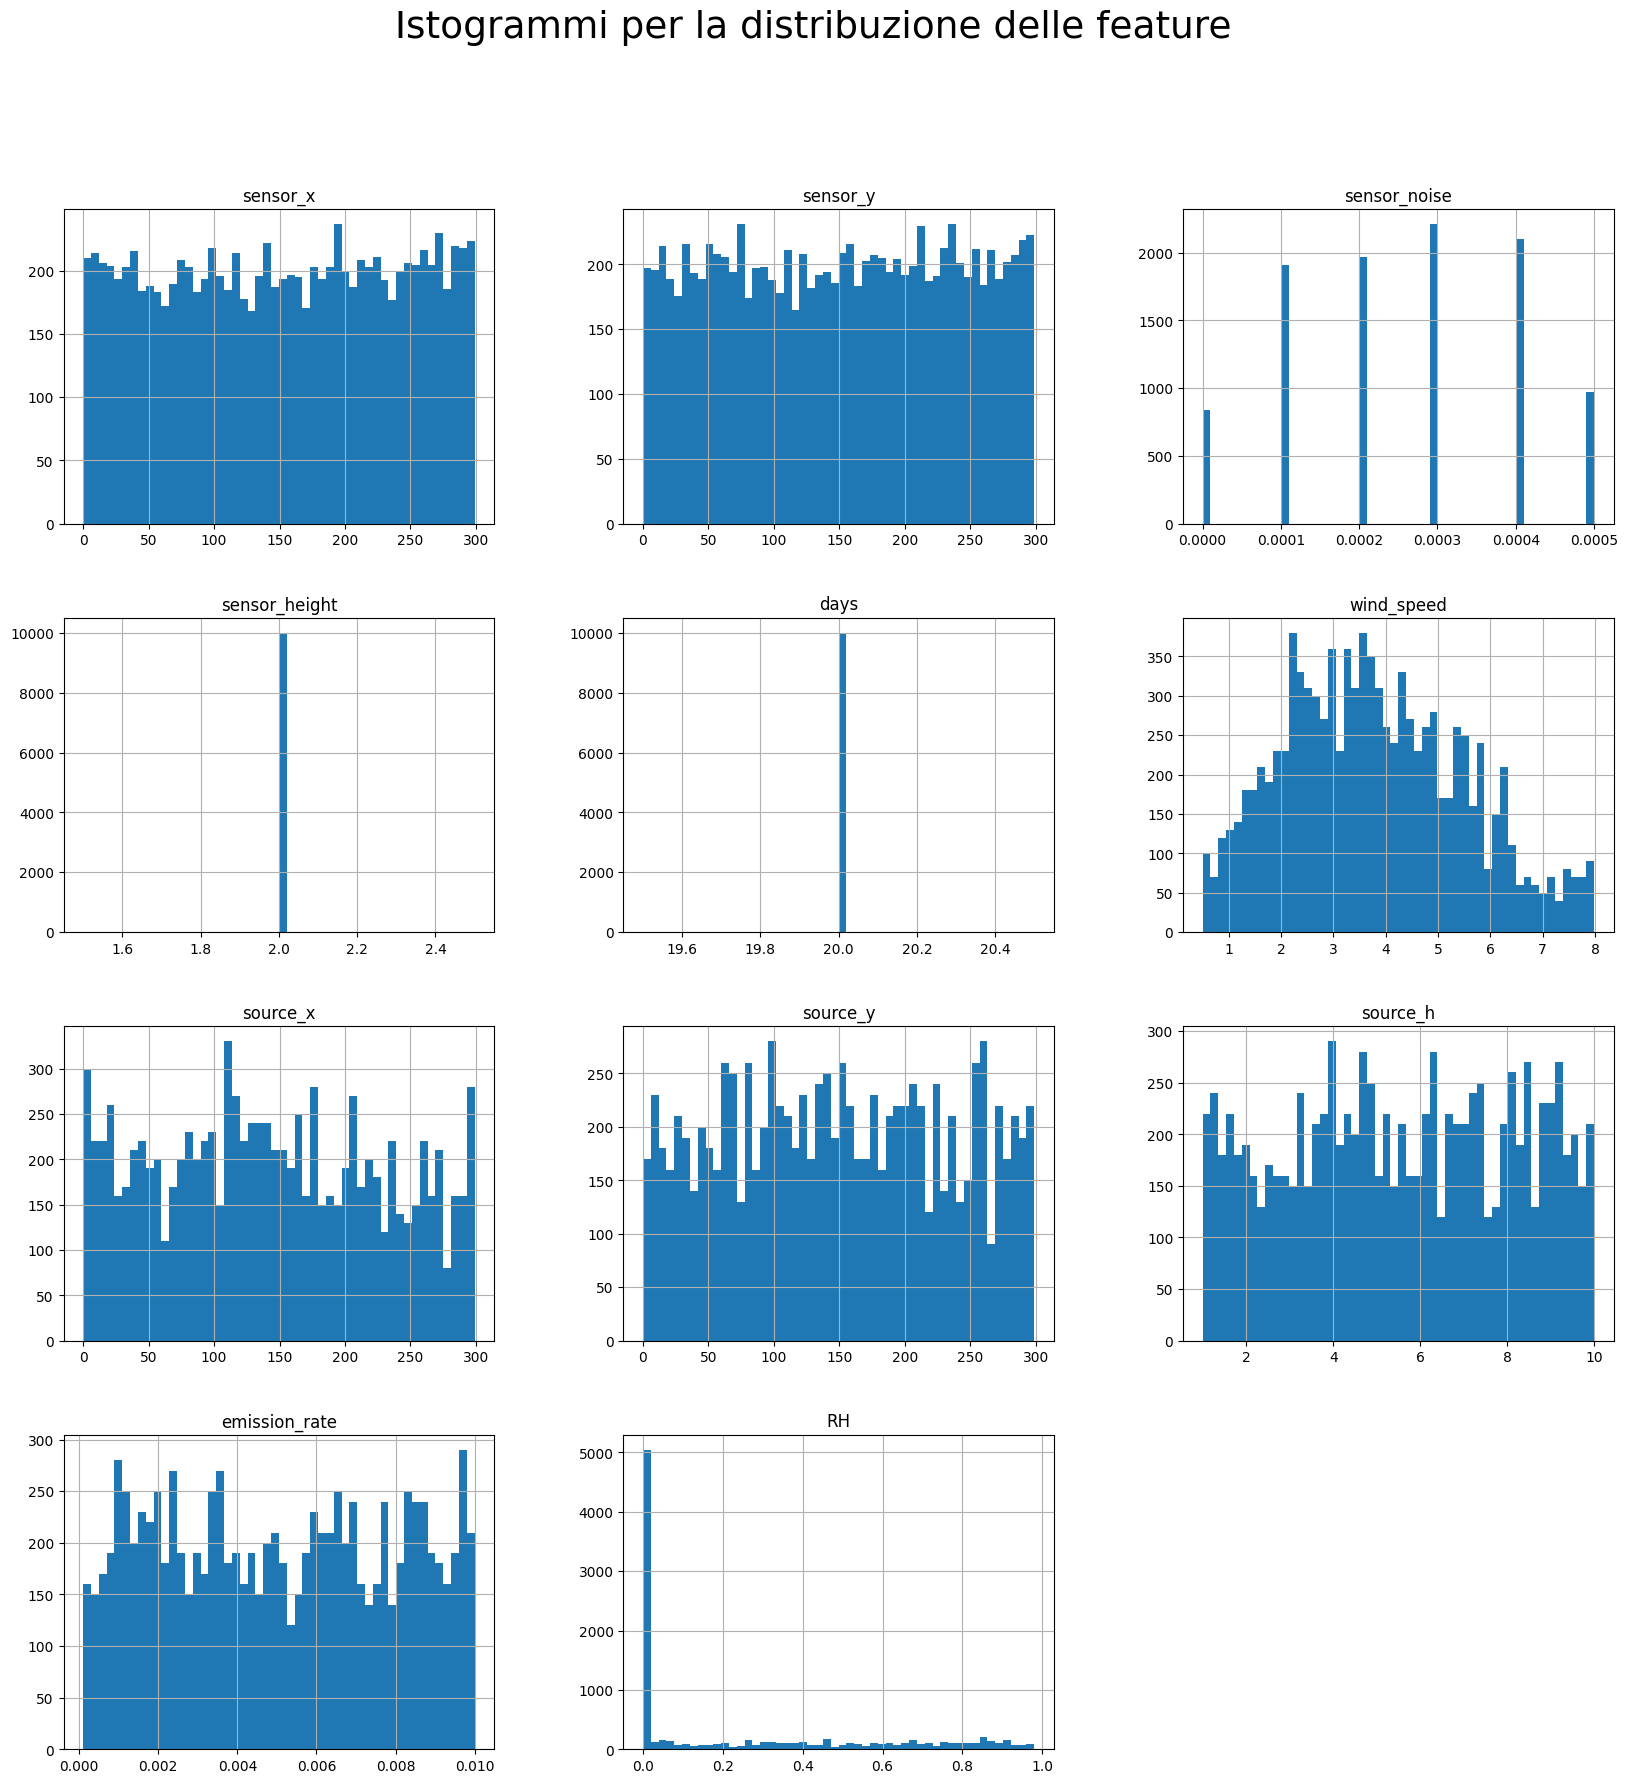

In [15]:
datset_copy_subset = datset_copy[["sensor_x", "sensor_y", "sensor_noise", "sensor_height", "days",
                                  "wind_speed", "source_x", "source_y", "source_h", "emission_rate", "RH"]]
datset_copy_subset.hist(figsize=(20, 20), bins=50)
plt.suptitle("Istogrammi per la distribuzione delle feature", fontsize=27)
plt.show()

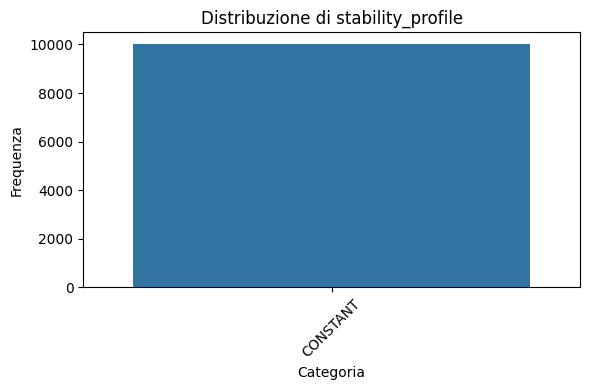

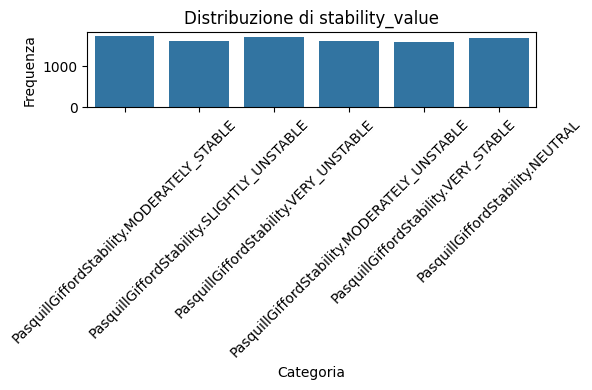

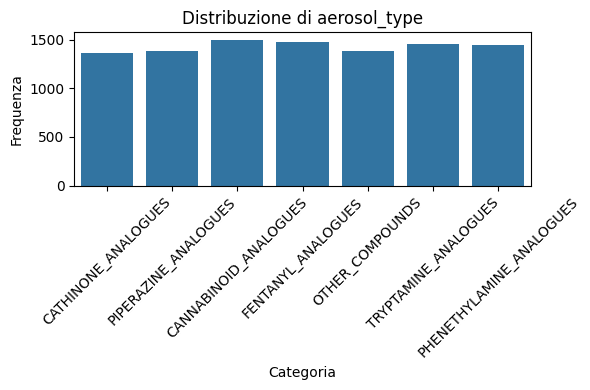

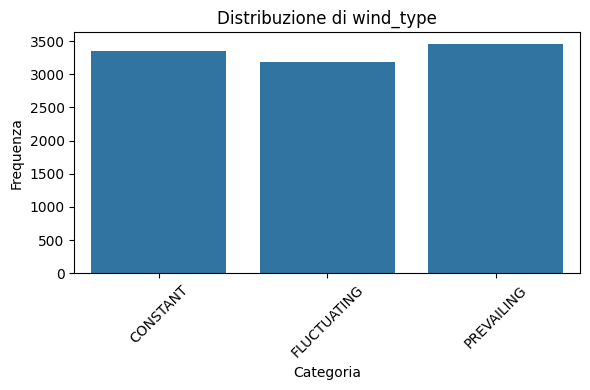

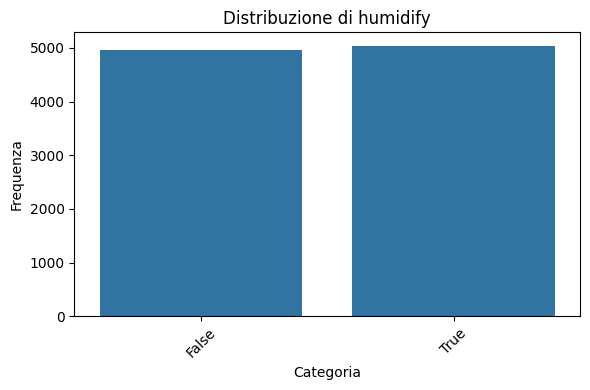

In [16]:
categorical_cols =["stability_profile", "stability_value", "aerosol_type", "wind_type", "humidify"]

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=datset_copy, x=col)
    plt.title(f"Distribuzione di {col}")
    plt.xlabel("Categoria")
    plt.ylabel("Frequenza")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
datset_copy = datset_copy.drop(columns=["simulation_id", "sensor_id", "stability_profile","sensor_height"])
datset_copy.drop(columns=["days"], inplace=True)
datset_copy.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_x            10000 non-null  float64
 1   sensor_y            10000 non-null  float64
 2   sensor_noise        10000 non-null  float64
 3   RH                  10000 non-null  float64
 4   humidify            10000 non-null  bool   
 5   wind_type           10000 non-null  object 
 6   wind_speed          10000 non-null  float64
 7   wind_dir            10000 non-null  object 
 8   stability_value     10000 non-null  object 
 9   aerosol_type        10000 non-null  object 
 10  source_x            10000 non-null  float64
 11  source_y            10000 non-null  float64
 12  source_h            10000 non-null  float64
 13  emission_rate       10000 non-null  float64
 14  real_concentration  10000 non-null  object 
 15  contratio_series    10000 non-null  object 
dtypes: bo

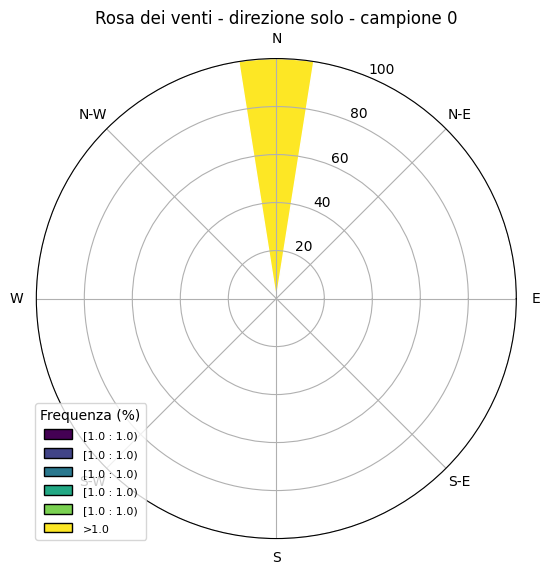

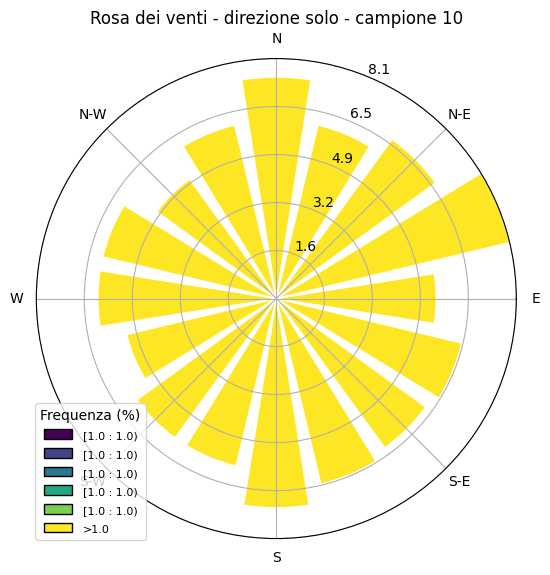

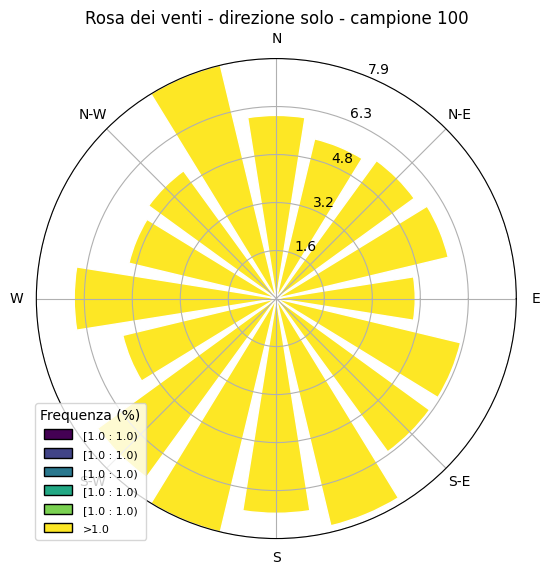

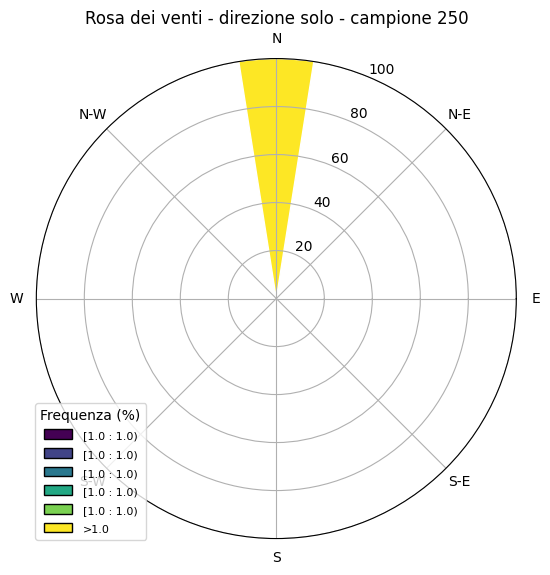

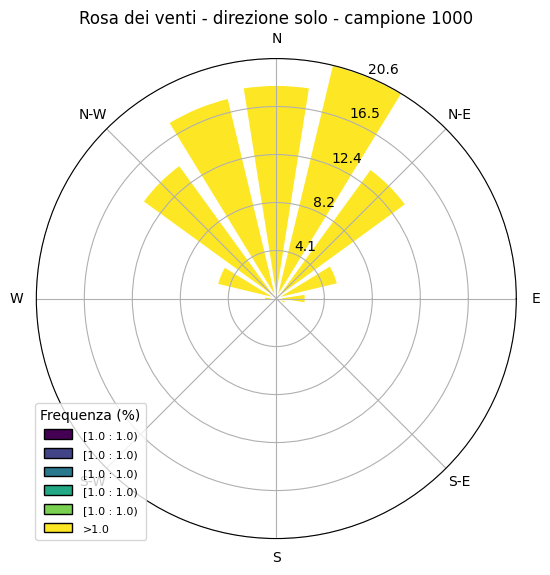

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

def plot_windrose_samples(dataset, indices):
    if isinstance(indices, int):
        indices = [indices]

    for i in indices:
        direzioni = np.array(dataset["wind_dir"].iloc[i])
        frequenze = np.ones_like(direzioni)  # peso uniforme per ogni direzione

        fig = plt.figure(figsize=(6,6))
        ax = WindroseAxes.from_ax(fig=fig)
        ax.bar(direzioni, frequenze, normed=True, opening=0.8, edgecolor='white')
        ax.set_legend(title="Frequenza (%)")
        ax.set_title(f"Rosa dei venti - direzione solo - campione {i}")
        plt.show()

plot_windrose_samples(datset_copy, [0, 10, 100, 250, 1000]) 


In [19]:
# Convert string arrays to numpy arrays and calculate mean direction for each entry
def calculate_mean_direction(wind_dir_array):
	if isinstance(wind_dir_array, str):
		# Convert string representation to numpy array
		wind_dir_array = np.fromstring(wind_dir_array.replace('[', '').replace(']', ''), sep=',')
	
	# Convert to radians
	wind_dir_rad = np.radians(wind_dir_array)
	
	# Calculate directional vectors
	cos_vals = np.cos(wind_dir_rad)
	sin_vals = np.sin(wind_dir_rad)
	
	# Calculate mean
	mean_cos = np.mean(cos_vals)
	mean_sin = np.mean(sin_vals)
	
	return mean_cos, mean_sin

# Apply to all wind directions
mean_directions = np.array([calculate_mean_direction(wd) for wd in datset_copy["wind_dir"]])

# Save mean wind direction components to dataset
datset_copy['wind_dir_cos'] = mean_directions[:, 0]
datset_copy['wind_dir_sin'] = mean_directions[:, 1]

In [20]:
datset_copy.drop(columns=["wind_dir"], inplace=True)

In [21]:
datset_copy_corr = datset_copy.copy()


wind_type_map = {
    "CONSTANT": 1,
    "FLUCTUATING": 2,
    "PREVAILING": 3
}

pg_stability_map = {
    "PasquillGiffordStability.VERY_UNSTABLE": 1,
    "PasquillGiffordStability.MODERATELY_UNSTABLE": 2,
    "PasquillGiffordStability.SLIGHTLY_UNSTABLE": 3,
    "PasquillGiffordStability.NEUTRAL": 4,
    "PasquillGiffordStability.MODERATELY_STABLE": 5,
    "PasquillGiffordStability.VERY_STABLE": 6
}

nps_type_map = {
    "CANNABINOID_ANALOGUES": 0,
    "CATHINONE_ANALOGUES": 1,
    "PHENETHYLAMINE_ANALOGUES": 2,
    "PIPERAZINE_ANALOGUES": 3,
    "TRYPTAMINE_ANALOGUES": 4,
    "FENTANYL_ANALOGUES": 5,
    "OTHER_COMPOUNDS": 6
}


datset_copy_corr['wind_type'] = datset_copy_corr['wind_type'].astype(str)
datset_copy_corr['stability_value'] = datset_copy_corr['stability_value'].astype(str)
datset_copy_corr['aerosol_type'] = datset_copy_corr['aerosol_type'].astype(str)

datset_copy_corr['wind_type'] = datset_copy_corr['wind_type'].map(wind_type_map)
datset_copy_corr['stability_value'] = datset_copy_corr['stability_value'].map(pg_stability_map)
datset_copy_corr['aerosol_type'] = datset_copy_corr['aerosol_type'].map(nps_type_map)

datset_copy_corr[["wind_type", "stability_value", "aerosol_type"]].head()

,wind_type,stability_value,aerosol_type
0,1,5,1
1,1,5,1
2,1,5,1
3,1,5,1
4,1,5,1


In [22]:
datset_copy_corr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_x            10000 non-null  float64
 1   sensor_y            10000 non-null  float64
 2   sensor_noise        10000 non-null  float64
 3   RH                  10000 non-null  float64
 4   humidify            10000 non-null  bool   
 5   wind_type           10000 non-null  int64  
 6   wind_speed          10000 non-null  float64
 7   stability_value     10000 non-null  int64  
 8   aerosol_type        10000 non-null  int64  
 9   source_x            10000 non-null  float64
 10  source_y            10000 non-null  float64
 11  source_h            10000 non-null  float64
 12  emission_rate       10000 non-null  float64
 13  real_concentration  10000 non-null  object 
 14  contratio_series    10000 non-null  object 
 15  wind_dir_cos        10000 non-null  float64
 16  wind_

In [23]:
datset_copy_corr.drop(columns=["contratio_series", "real_concentration"], inplace=True)

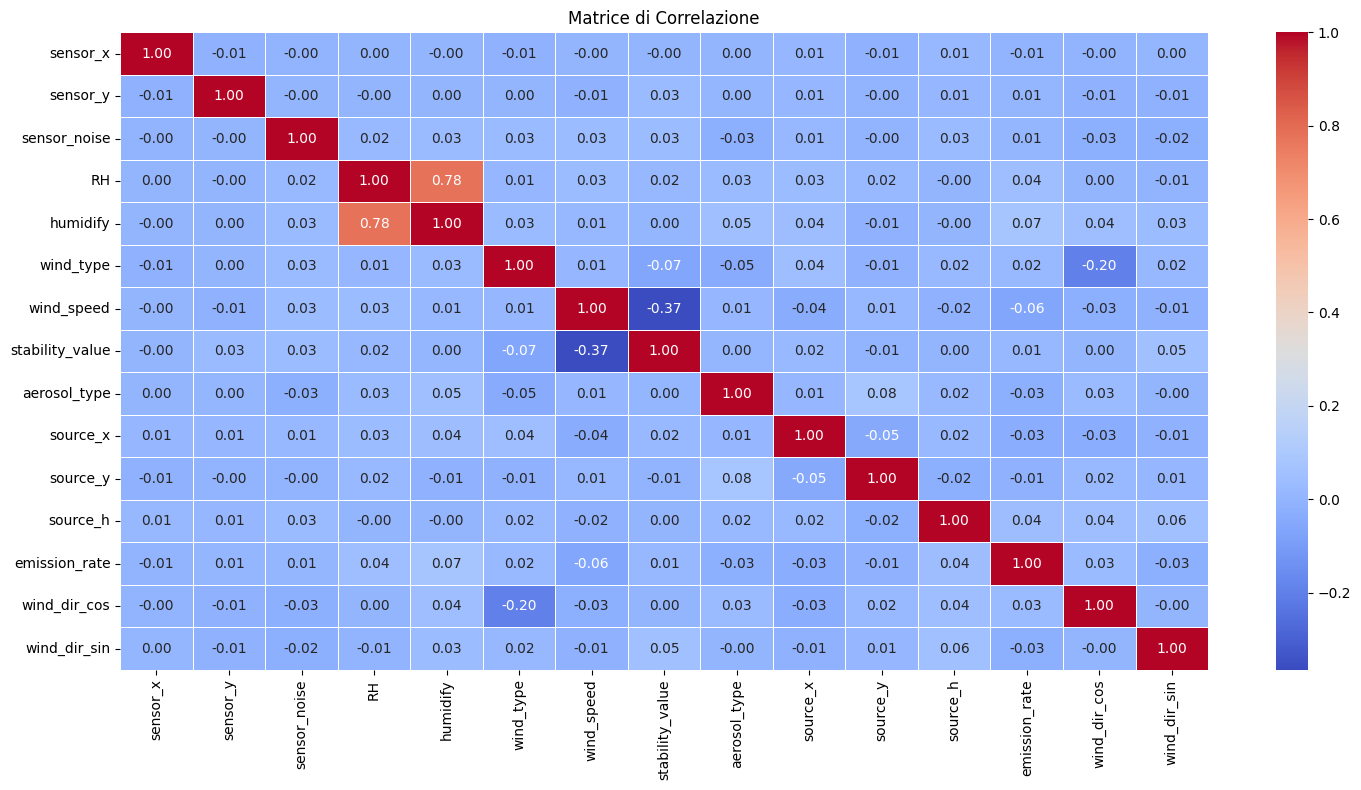

In [24]:
matrix_corr=datset_copy_corr.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm',fmt=".2f", linewidths=0.5)
plt.title("Matrice di Correlazione")
plt.tight_layout()
plt.show()

In [25]:
datset_copy.drop(columns=["humidify"], inplace=True)
datset_copy.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_x            10000 non-null  float64
 1   sensor_y            10000 non-null  float64
 2   sensor_noise        10000 non-null  float64
 3   RH                  10000 non-null  float64
 4   wind_type           10000 non-null  object 
 5   wind_speed          10000 non-null  float64
 6   stability_value     10000 non-null  object 
 7   aerosol_type        10000 non-null  object 
 8   source_x            10000 non-null  float64
 9   source_y            10000 non-null  float64
 10  source_h            10000 non-null  float64
 11  emission_rate       10000 non-null  float64
 12  real_concentration  10000 non-null  object 
 13  contratio_series    10000 non-null  object 
 14  wind_dir_cos        10000 non-null  float64
 15  wind_dir_sin        10000 non-null  float64
dtypes: fl

In [36]:
 # Prepara encoder per le stringhe
from sklearn.preprocessing import LabelEncoder

le_wind_type = LabelEncoder()
le_aerosol = LabelEncoder()
le_stability = LabelEncoder()

# Fit encoder su tutto il dataset una volta
le_wind_type.fit(datset_copy['wind_type'])
le_aerosol.fit(datset_copy['aerosol_type'])
le_stability.fit(datset_copy['stability_value'])

datset_copy['wind_type']=le_wind_type.transform(datset_copy['wind_type'])
datset_copy['aerosol_type']=le_aerosol.transform(datset_copy['aerosol_type'])
datset_copy['stability_value']=le_stability.transform(datset_copy['stability_value'])

In [39]:
print(datset_copy.columns)

Index(['sensor_x', 'sensor_y', 'sensor_noise', 'RH', 'wind_type', 'wind_speed',
       'stability_value', 'aerosol_type', 'source_x', 'source_y', 'source_h',
       'emission_rate', 'real_concentration', 'contratio_series',
       'wind_dir_cos', 'wind_dir_sin'],
      dtype='object')


In [37]:
datset_copy.head()

,sensor_x,sensor_y,sensor_noise,RH,wind_type,wind_speed,stability_value,aerosol_type,source_x,source_y,source_h,emission_rate,real_concentration,contratio_series,wind_dir_cos,wind_dir_sin
0,1.0,2.0,0.0004,0.68,0,2.05,0,1,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"2.036756289725936e-10,7.746403728087358e-11,1....",1.0,0.0
1,274.0,21.0,0.0004,0.68,0,2.05,0,1,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"5.400567843799803e-10,7.896154493629639e-11,1....",1.0,0.0
2,166.0,103.0,0.0004,0.68,0,2.05,0,1,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"0.0,3.738415300353007e-10,8.896007738156253e-1...",1.0,0.0
3,130.0,229.0,0.0004,0.68,0,2.05,0,1,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"2.2418948171564444e-10,3.0737799433089084e-11,...",1.0,0.0
4,123.0,274.0,0.0004,0.68,0,2.05,0,1,276.0,71.0,6.08,0.0031,sim_0_conc_real_0408_v3.npy,"3.7239198523556254e-11,5.367155129155546e-10,3...",1.0,0.0


In [38]:
# save dataset_copy to a new CSV file
datset_copy.to_csv("dataset/nps_simulated_dataset_gaussiano_0608_processed.csv", index=False)